In [8]:
import os
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp
import scipy.stats as stats
import time
import itertools
import statsmodels.api as sm
import numpy.ma as ma
from scipy.stats.stats import pearsonr, normaltest
from scipy.spatial.distance import correlation
from sklearn.model_selection import train_test_split
os.getcwd()
os.chdir(r'C:\Users\Haneef Usmani\Desktop\STAT 303-2\Project')

In [2]:
flights_clean = pd.read_csv('flights_clean.csv')

In [5]:
flights = flights_clean.sample(10000, random_state=1) # only sampled 10000 since the dataset is too large

In [9]:
train, test = train_test_split(flights, test_size=0.2)

In [20]:
# drop all categorical variables from train
train_drop = train.drop(['airline', 'destination_airport', 'origin_airport', 'state_destination', 'state_origin'], axis=1)

In [21]:
X = train[['airline', 'day', 'day_of_week', 'destination_airport', 'destination_latitude', 'destination_longitude', 'distance', 'month', 'origin_airport', 'origin_latitude', 'origin_longitude', 'scheduled_arrival', 'scheduled_departure', 'scheduled_time', 'state_destination', 'state_origin', 'taxi_in', 'taxi_out', 'day_of_year', 'origin_temperature', 'destination_temperature']]
# take out all categorical variables
X = X.drop(['airline', 'destination_airport', 'origin_airport', 'state_destination', 'state_origin'], axis=1)

In [22]:
#Function to develop a model based on all predictors in predictor_subset
def processSubset(predictor_subset):
    # Fit model on feature_set and calculate R-squared
    model = smf.ols('departure_delay~' + '+'.join(predictor_subset),data = train_drop).fit()
    Rsquared = model.rsquared
    return {"model":model, "Rsquared":Rsquared}
#Function to select the best model amongst all models with 'k' predictors
def getBest_model(k):
    tic = time.time()
    results = []
    for combo in itertools.combinations(X.columns, k):
        results.append(processSubset((list(combo))))

    # Wrap everything up in a dataframe
    models = pd.DataFrame(results)

    # Choose the model with the highest RSS
    best_model = models.loc[models['Rsquared'].argmax()]
    
    toc = time.time()
    print("Processed", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")
    return best_model

In [23]:
#Function to select the best model amongst the best models for 'k' predictors, where k = 1,2,3,..
models_best = pd.DataFrame(columns=["Rsquared", "model"])
tic = time.time()
for i in range(1,1+X.shape[1]):
    models_best.loc[i] = getBest_model(i)
toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Processed 16 models on 1 predictors in 0.13599610328674316 seconds.
Processed 120 models on 2 predictors in 1.0080420970916748 seconds.
Processed 560 models on 3 predictors in 5.312252759933472 seconds.
Processed 1820 models on 4 predictors in 28.142412424087524 seconds.
Processed 4368 models on 5 predictors in 74.10345697402954 seconds.
Processed 8008 models on 6 predictors in 165.0827398300171 seconds.
Processed 11440 models on 7 predictors in 334.49633288383484 seconds.
Processed 12870 models on 8 predictors in 294.8457546234131 seconds.
Processed 11440 models on 9 predictors in 280.21948742866516 seconds.
Processed 8008 models on 10 predictors in 203.19205713272095 seconds.
Processed 4368 models on 11 predictors in 113.8034520149231 seconds.
Processed 1820 models on 12 predictors in 54.26904535293579 seconds.
Processed 560 models on 13 predictors in 18.86642026901245 seconds.
Processed 120 models on 14 predictors in 3.9664971828460693 seconds.
Processed 16 models on 15 predictors i

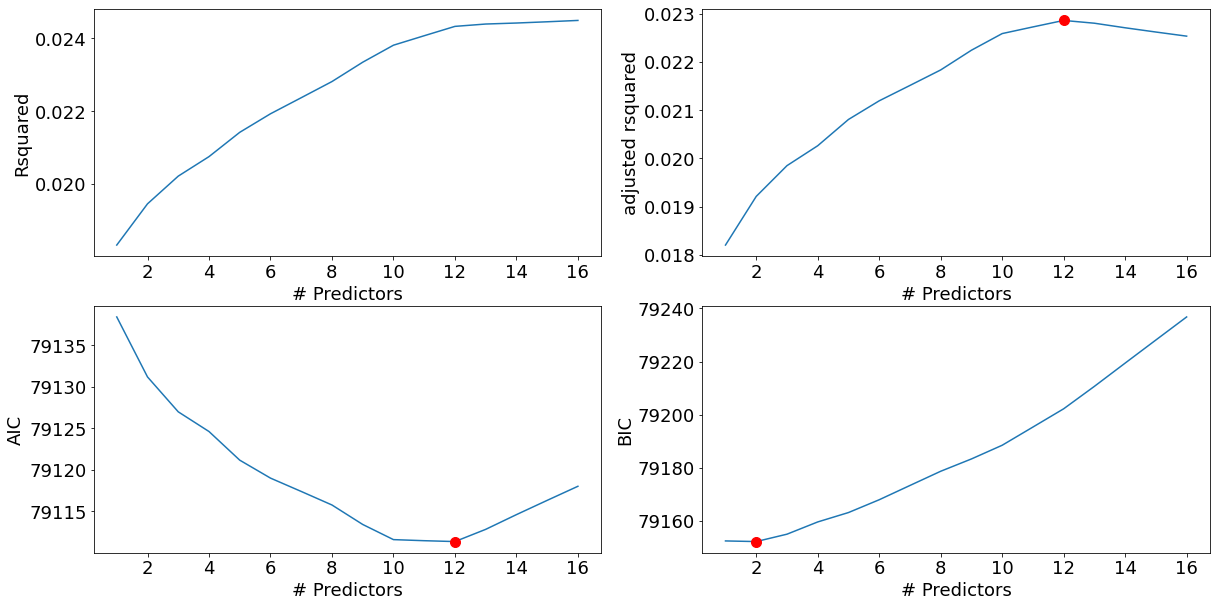

In [24]:
def best_sub_plots():
    plt.figure(figsize=(20,10))
    plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

    # Set up a 2x2 grid so we can look at 4 plots at once
    plt.subplot(2, 2, 1)

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector
    plt.plot(models_best["Rsquared"])
    plt.xlabel('# Predictors')
    plt.ylabel('Rsquared')

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector

    rsquared_adj = models_best.apply(lambda row: row[1].rsquared_adj, axis=1)

    plt.subplot(2, 2, 2)
    plt.plot(rsquared_adj)
    plt.plot(1+rsquared_adj.argmax(), rsquared_adj.max(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('adjusted rsquared')

    # We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
    aic = models_best.apply(lambda row: row[1].aic, axis=1)

    plt.subplot(2, 2, 3)
    plt.plot(aic)
    plt.plot(1+aic.argmin(), aic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('AIC')

    bic = models_best.apply(lambda row: row[1].bic, axis=1)

    plt.subplot(2, 2, 4)
    plt.plot(bic)
    plt.plot(1+bic.argmin(), bic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('BIC')
best_sub_plots()

In [25]:
best_subset_model = models_best.loc[12,'model'] # best model based on AIC and adjusted R-squared
models_best.loc[12,'model'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        departure_delay   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     16.60
Date:                Sun, 05 Mar 2023   Prob (F-statistic):           1.47e-35
Time:                        15:42:26   Log-Likelihood:                -39543.
No. Observations:                8000   AIC:                         7.911e+04
Df Residuals:                    7987   BIC:                         7.920e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 -50.7215     18.405     -2.756      0.006     -86.800     -14.643
day                         1.9916      0.615      3.241      0.001       0.787       3.196
day_of_week                -0.4078      0.193     -2.113      0.035      -0.786      -0.029
destination_latitude       -0.2349      0.083     -2.833      0.005      -0.398      -0.072
distance                    0.0009      0.001      1.450      0.147      -0.000       0.002
month                      61.5388     18.672      3.296      0.001      24.937      98.140
origin_latitude            -0.1085      0.075     -1.451      0.147      -0.255       0.038
scheduled_arrival           0.0032      0.002      1.863      0.062      -0.000       0.007
scheduled_departure         0.0137      0.002      7.586      0.000       0.010       0.017
taxi_in                     0.1408      0.063      2.238      0.025       0.018       0.264
taxi_out                    0.1133      0.039      2.882      0.004       0.036       0.190
day_of_year                -2.0241      0.613     -3.302      0.001      -3.226      -0.822
destination_temperature    -0.0918      0.027     -3.437      0.001      -0.144      -0.039
==============================================================================
Omnibus:                     9005.558   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1154585.390
Skew:                           5.712   Prob(JB):                         0.00
Kurtosis:                      60.734   Cond. No.                     1.08e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.08e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [6]:
# variables most corrleated with departure delay
flights_clean.corr().departure_delay.sort_values(ascending=False)

departure_delay        1.000000
scheduled_departure    0.110211
scheduled_arrival      0.097523
taxi_out               0.058515
origin_longitude       0.031857
scheduled_time         0.027799
longitude              0.025585
distance               0.024106
taxi_in                0.012784
latitude               0.002190
day                   -0.000176
origin_latitude       -0.003755
day_of_week           -0.011510
day_of_year           -0.021968
month                 -0.021994
Name: departure_delay, dtype: float64

In [8]:
model = smf.ols(formula='departure_delay ~ scheduled_departure + scheduled_arrival + taxi_out', data=flights_clean).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        departure_delay   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                 3.145e+04
Date:                Wed, 01 Mar 2023   Prob (F-statistic):               0.00
Time:                        13:25:07   Log-Likelihood:            -2.8774e+07
No. Observations:             5730032   AIC:                         5.755e+07
Df Residuals:                 5730028   BIC:                         5.755e+07
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -7.1776      0.057   -125.766      0.000      -7.289      -7.066
scheduled_departure     0.0106   7.44e-05    143.207      0.000       0.011       0.011
scheduled_arrival       0.0045   7.11e-05     63.589      0.000       0.004       0.005
taxi_out                0.2373      0.002    137.665      0.000       0.234       0.241
==============================================================================
Omnibus:                  7834411.954   Durbin-Watson:                   1.873
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       3900725472.306
Skew:                           7.694   Prob(JB):                         0.00
Kurtosis:                     129.891   Cond. No.                     4.75e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.75e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""